In [1]:
# Import all required libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.utils import image_dataset_from_directory

#### Set all the Constants

In [2]:
# ⚙️ Set important constants
BATCH_SIZE = 32          # Number of images processed together in one pass
IMAGE_SIZE = 256         # Height and width of the image
CHANNELS = 3             # RGB color channels
EPOCHS = 50              # Number of times the entire dataset is passed through the model


### Import data into tensorflow dataset object
We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [3]:
# Load dataset from directory using TensorFlow utility
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\DELL\Desktop\Naveen Gill\PlantVillage",              # Directory containing dataset
    seed=123,                    # Seed for shuffling
    shuffle=True,                # Shuffle the dataset for randomness
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  # Resize all images
    batch_size=BATCH_SIZE        # Batch size
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch[0].shape)

(32, 256, 256, 3)
()


In [6]:
# Inspect a single batch from the dataset
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)         # Shape of image batch: (32, 256, 256, 3)
    print(labels_batch.numpy())      # Corresponding labels for the batch


(32, 256, 256, 3)
[0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 0 0 1 1 0]


As we can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

#### Visualize some of the images from our dataset

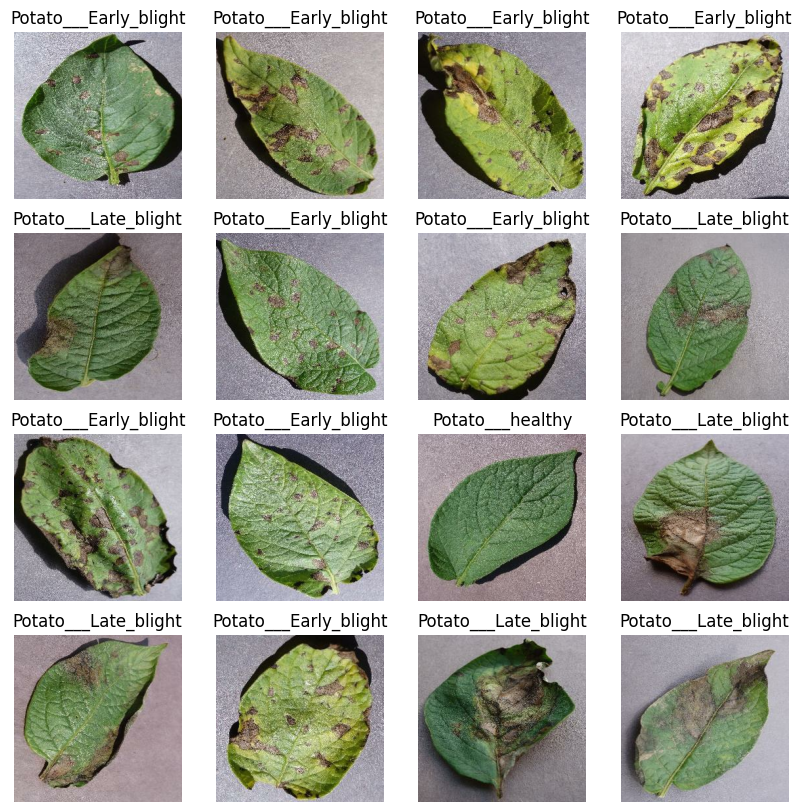

In [8]:
# Visualize 16 images from the dataset with their labels
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))     # Show image
        plt.title(class_names[labels_batch[i]])                # Show label
        plt.axis("off")

### Function to Split Dataset
##### Dataset should be bifurcated into 3 subsets, namely:

- Training: Dataset to be used while training
- Validation: Dataset to be tested against while training
- Test: Dataset to be tested against after we trained a model

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54) # list[:54]
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54) # list[54:]
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
# Split dataset into training, validation, and test sets
train_size = 0.8
train_ds = dataset.take(int(train_size * len(dataset)))
test_ds = dataset.skip(int(train_size * len(dataset)))
val_ds = test_ds.take(int(0.1 * len(dataset)))
test_ds = test_ds.skip(int(0.1 * len(dataset)))

In [17]:
# now all in a function

In [18]:
# Alternatively, define a reusable function to split the dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1         # Ensure splits sum to 1
    ds_size = len(ds)                                          # Total dataset size

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)                # Shuffle dataset for randomness

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)                             # First chunk = train
    val_ds = ds.skip(train_size).take(val_size)                # Second chunk = validation
    test_ds = ds.skip(train_size).skip(val_size)               # Remaining = test

    return train_ds, val_ds, test_ds

In [19]:
# Partition the dataset using the above function
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [20]:
len(train_ds)

54

In [21]:
len(val_ds)

6

In [22]:
len(test_ds)

8

In [24]:
# Prepare the datasets for efficient training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model
#### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [26]:
# Resize and normalize images
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.Rescaling(1./255),
])


### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [31]:
# Data augmentation for increasing training data variety
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.2),
])


In [32]:
# Apply data augmentation only on training data
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)      # Apply augmentations to each batch
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
# Build the CNN Model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Define input shape for building model
n_classes = 3  # Number of output classes

In [34]:
model = models.Sequential([
    resize_and_rescale,  # Resize and normalize input
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),          # Downsample the features
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),                      # Flatten the 2D output to 1D
    layers.Dense(64, activation='relu'),   # Fully connected layer
    layers.Dense(n_classes, activation='softmax'),  # Final output layer for classification
])

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Build the model with specified input shape
model.build(input_shape=input_shape)
model.summary()  # Display the model's structure


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Compile the model
model.compile(
    optimizer='adam',       # Use Adam optimizer
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),  # Use crossentropy for multi-class labels
    metrics=['accuracy']    # Track accuracy during training
)

In [37]:
# Train the model
history = model.fit(
    train_ds,                # Training dataset
    batch_size=BATCH_SIZE,   # Batch size
    validation_data=val_ds,  # Validation dataset
    verbose=1,               # Show training progress
    epochs=80            # Number of training epochs
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - accuracy: 0.4977 - loss: 0.9522 - val_accuracy: 0.4740 - val_loss: 0.9456
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 16s 294ms/step - accuracy: 0.4727 - loss: 0.8937 - val_accuracy: 0.6302 - val_loss: 0.7933
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 305ms/step - accuracy: 0.6204 - loss: 0.8154 - val_accuracy: 0.7500 - val_loss: 0.5541
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 309ms/step - accuracy: 0.8027 - loss: 0.5174 - val_accuracy: 0.6250 - val_loss: 0.8378
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 18s 335ms/step - accuracy: 0.7765 - loss: 0.5877 - val_accuracy: 0.8698 - val_loss: 0.3100
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 384ms/step - accuracy: 0.8628 - loss: 0.3287 - val_accuracy: 0.9167 - val_loss: 0.1971
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 21s 380ms/step - accuracy: 0.8978 - loss: 0.2868 - val_accuracy: 0.8438 - val_loss: 0.3693
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 419ms/step - accuracy: 0.9224 - loss: 0.2409 - val_accu

In [38]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9136 - loss: 0.1864


In [39]:
scores

[0.1648852676153183, 0.9296875]

In [40]:
history

In [41]:
print(history.params)


{'verbose': 1, 'epochs': 50, 'steps': 54}


In [42]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [44]:
len(history.history['loss'])

50

In [45]:
history.history['loss'][:5]

[0.9179993271827698,
 0.8854886293411255,
 0.7531117796897888,
 0.5096533894538879,
 0.4902113378047943]

In [53]:
# Extracting accuracy and validation accuracy from training history
acc = history.history['accuracy']  # Training accuracy for each epoch
val_acc = history.history['val_accuracy']  # Validation accuracy for each epoch

# Extracting training and validation loss from training history
loss = history.history['loss']  # Training loss for each epoch
val_loss = history.history['val_loss']  # Validation loss for each epoch

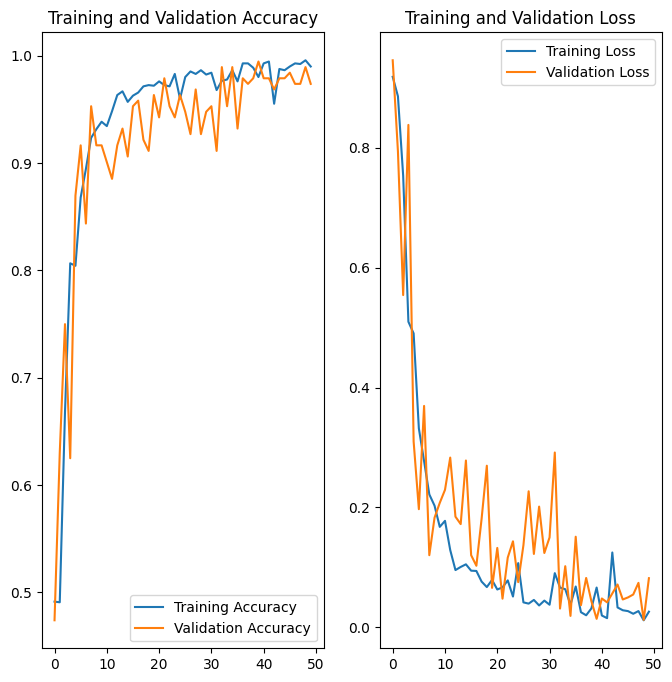

In [54]:
# Setting the figure size for plotting
plt.figure(figsize=(8, 8))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.plot(range(EPOCHS), acc, label='Training Accuracy')  # Plotting training accuracy
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')  # Plotting validation accuracy
plt.legend(loc='lower right')  # Position of legend
plt.title('Training and Validation Accuracy')  # Title of the plot

# Plotting training and validation loss
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.plot(range(EPOCHS), loss, label='Training Loss')  # Plotting training loss
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')  # Plotting validation loss
plt.legend(loc='upper right')  # Position of legend
plt.title('Training and Validation Loss')  # Title of the plot
plt.show()  # Show the plots


In [59]:
for images_batch, labels_batch in test_ds.take(1):

    print(image_batch[0])

tf.Tensor(
[[[162. 166. 177.]
  [166. 170. 181.]
  [177. 181. 192.]
  ...
  [165. 163. 176.]
  [160. 158. 171.]
  [162. 160. 173.]]

 [[207. 211. 222.]
  [175. 179. 190.]
  [141. 145. 156.]
  ...
  [157. 155. 168.]
  [153. 151. 164.]
  [156. 154. 167.]]

 [[186. 190. 201.]
  [182. 186. 197.]
  [195. 199. 210.]
  ...
  [157. 155. 168.]
  [153. 151. 164.]
  [154. 152. 165.]]

 ...

 [[155. 153. 166.]
  [153. 151. 164.]
  [157. 155. 168.]
  ...
  [142. 139. 150.]
  [142. 139. 150.]
  [127. 124. 135.]]

 [[185. 183. 196.]
  [173. 171. 184.]
  [162. 160. 173.]
  ...
  [148. 145. 156.]
  [130. 127. 138.]
  [128. 125. 136.]]

 [[176. 174. 187.]
  [175. 173. 186.]
  [175. 173. 186.]
  ...
  [111. 108. 119.]
  [143. 140. 151.]
  [139. 136. 147.]]], shape=(256, 256, 3), dtype=float32)


In [60]:
for images_batch, labels_batch in test_ds.take(1):

    print(image_batch[0].numpy())

[[[162. 166. 177.]
  [166. 170. 181.]
  [177. 181. 192.]
  ...
  [165. 163. 176.]
  [160. 158. 171.]
  [162. 160. 173.]]

 [[207. 211. 222.]
  [175. 179. 190.]
  [141. 145. 156.]
  ...
  [157. 155. 168.]
  [153. 151. 164.]
  [156. 154. 167.]]

 [[186. 190. 201.]
  [182. 186. 197.]
  [195. 199. 210.]
  ...
  [157. 155. 168.]
  [153. 151. 164.]
  [154. 152. 165.]]

 ...

 [[155. 153. 166.]
  [153. 151. 164.]
  [157. 155. 168.]
  ...
  [142. 139. 150.]
  [142. 139. 150.]
  [127. 124. 135.]]

 [[185. 183. 196.]
  [173. 171. 184.]
  [162. 160. 173.]
  ...
  [148. 145. 156.]
  [130. 127. 138.]
  [128. 125. 136.]]

 [[176. 174. 187.]
  [175. 173. 186.]
  [175. 173. 186.]
  ...
  [111. 108. 119.]
  [143. 140. 151.]
  [139. 136. 147.]]]


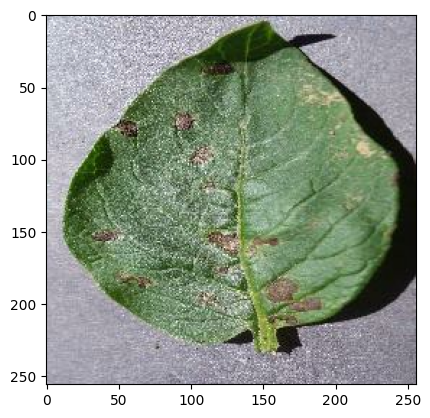

In [58]:
for images_batch, labels_batch in test_ds.take(1):

    plt.imshow(image_batch[0].numpy().astype('uint8'))

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
predicted label: Potato___Late_blight


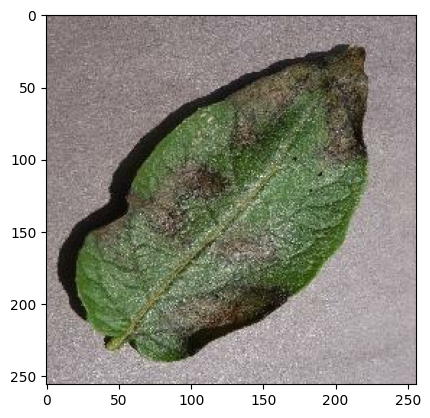

In [61]:
# ------------------------------
# Run prediction on a sample image
# ------------------------------

import numpy as np  # Importing NumPy for numerical operations

# Loop through one batch from the test dataset
for images_batch, labels_batch in test_ds.take(1):
    
    # Select the first image and label from the batch
    first_image = images_batch[0].numpy().astype('uint8')  # Convert image tensor to uint8 NumPy array
    first_label = labels_batch[0].numpy()  # Convert label tensor to integer
    
    print("first image to predict")
    plt.imshow(first_image)  # Display the image
    print("actual label:", class_names[first_label])  # Print the actual class name
    
    # Predicting the label of the entire batch
    batch_prediction = model.predict(images_batch)  # Model prediction on batch
    # Print the predicted class name of the first image
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])  # Index with highest prediction probability


In [62]:
# ------------------------------
# Function for inference on a single image
# ------------------------------

def predict(model, img):
    # Convert image to array and expand dimensions to match model input shape (1, height, width, channels)
    img_array = tf.keras.preprocessing.image.img_to_array(img)  # Convert image to array
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Get predictions from model
    predictions = model.predict(img_array)  # Predict the class probabilities
    
    # Get the class with highest probability
    predicted_class = class_names[np.argmax(predictions[0])]  # Predicted class name
    # Get the confidence level (as percentage)
    confidence = round(100 * (np.max(predictions[0])), 2)  # Confidence of the prediction
    return predicted_class, confidence  # Return the predicted class and confidence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


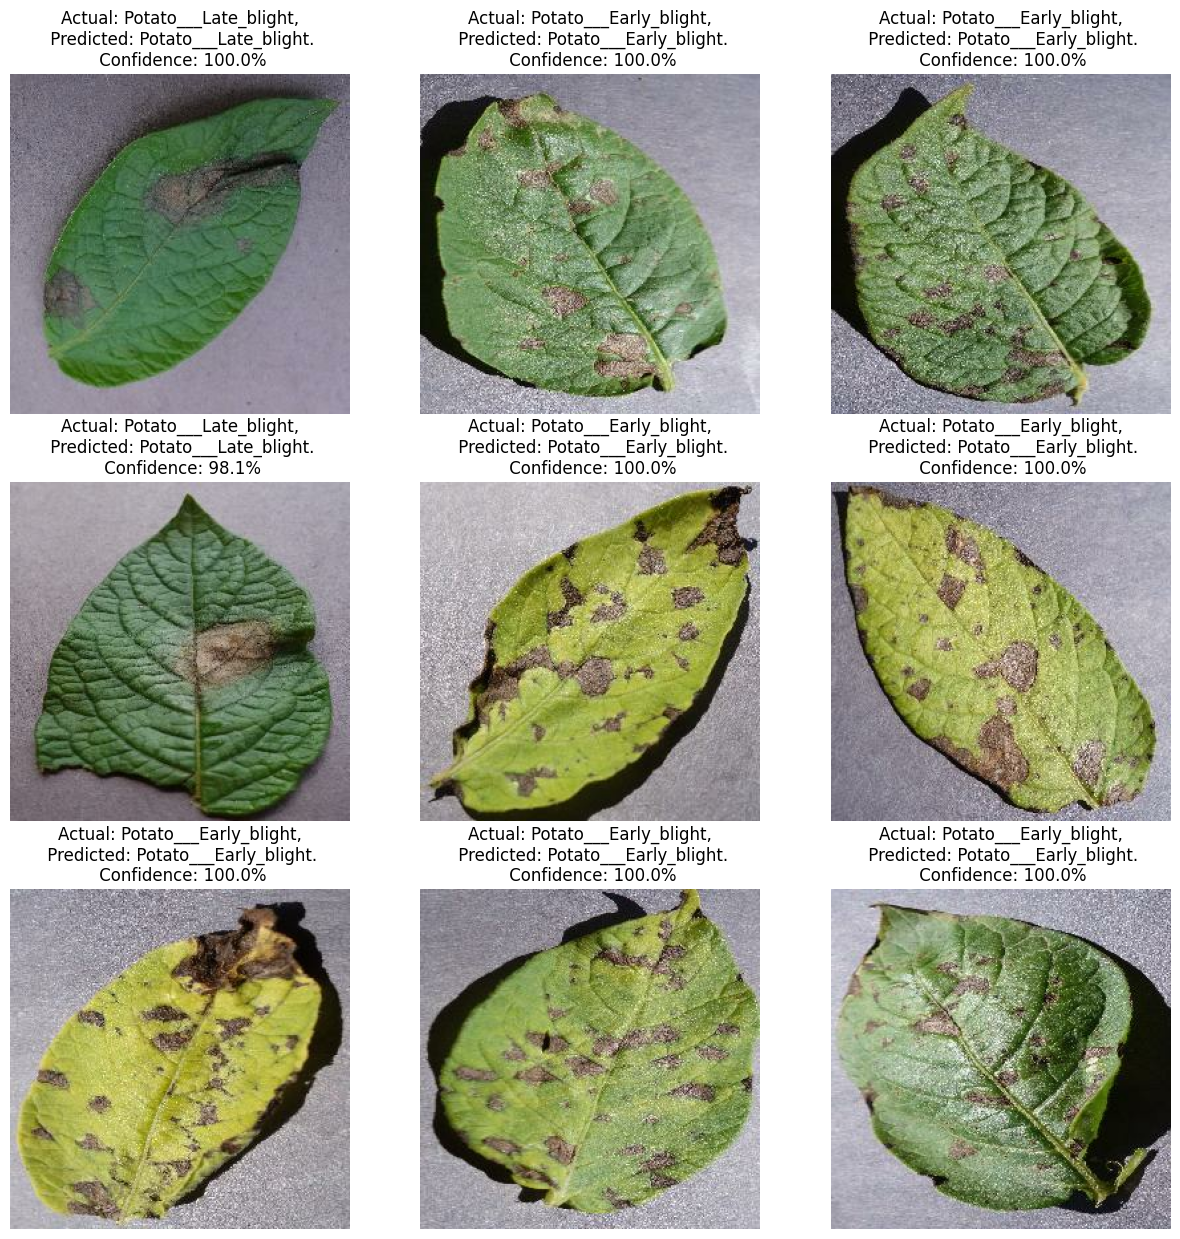

In [63]:
# ------------------------------
# Run inference on a few sample images
# ------------------------------

plt.figure(figsize=(15, 15))  # Set figure size for 3x3 grid
for images, labels in test_ds.take(1):  # Take one batch from test dataset
    for i in range(9):  # Loop through first 9 images in the batch
        ax = plt.subplot(3, 3, i + 1)  # Create a subplot in 3x3 grid
        plt.imshow(images[i].numpy().astype("uint8"))  # Display image

        # Get prediction for each image
        predicted_class, confidence = predict(model, images[i].numpy())  # Run prediction
        actual_class = class_names[labels[i]]  # Get actual class label

        # Set title with actual, predicted class and confidence
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")  # Hide axes for cleaner look


#### Saving the Model
We append the model to the list of models as a new version

In [69]:
import os

# Define your model directory
models_dir = r"C:\Users\DELL\Desktop\Naveen Gill\Potato Disease Classification\models"

# Make sure the folder exists
os.makedirs(models_dir, exist_ok=True)

# Get all model files with numeric names (e.g., 1.keras, 2.keras)
existing_versions = [
    int(f.split('.')[0]) for f in os.listdir(models_dir)
    if f.split('.')[0].isdigit() and f.endswith(".keras")
]

# Determine the next model version
model_version = max(existing_versions + [0]) + 1

# Full path to save the model
model_path = os.path.join(models_dir, f"{model_version}.keras")

# Save the model
model.save(model_path)
